# **Madrid Restaurant review reviewer**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import LlamaForCausalLM, LlamaTokenizer, pipeline
from tqdm.auto import tqdm
import json
import os
from huggingface_hub import login
from joblib import Parallel, delayed
import multiprocessing
import concurrent.futures
import psutil

/Users/johanbarreiro/anaconda3/envs/NLP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the data

In [ ]:
import zipfile
import pandas as pd
import os

# Get the current working directory
current_directory = os.getcwd()

# Name of the zip file and the CSV file inside it
zip_file_name = 'data.zip'
csv_file_name = 'Madrid_reviews.csv'

# Path to the zip file
zip_file_path = os.path.join(current_directory, zip_file_name)

# Extract and read the CSV file
with zipfile.ZipFile(zip_file_path, 'r') as z:
    with z.open(csv_file_name) as f:
        df = pd.read_csv(f)


# Set this new column as the index of df
df.set_index(df['restaurant_name'] + '_' + df['review_id'].astype(str), inplace=True)

# Display the first few rows of the DataFrame
(df.head())


,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
Sushi_Yakuza_review_731778139,0,1,Sushi_Yakuza,4,Positive,review_731778139,Good sushi option,"The menu of Yakuza is a bit of a lottery, some...","The menu of Yakuza is a bit of a lottery, some...","December 10, 2019",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
Azotea_Forus_Barcelo_review_766657436,10,11,Azotea_Forus_Barcelo,1,Negative,review_766657436,Light up your table at night,Check your bill when you cancel just in case y...,Check your bill when you cancel just in case y...,"August 23, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
Level_Veggie_Bistro_review_749493592,11,12,Level_Veggie_Bistro,5,Positive,review_749493592,Delicious,I had the yuca profiteroles and the veggie bur...,I had the yuca profiteroles and the veggie bur...,"March 6, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
Sto_Globo_Sushi_Room_review_772422246,12,13,Sto_Globo_Sushi_Room,5,Positive,review_772422246,Loved this place,A friend recommended this place as one of the ...,A friend recommended this place as one of the ...,"September 29, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
Azotea_Forus_Barcelo_review_761855600,13,14,Azotea_Forus_Barcelo,5,Positive,review_761855600,Amazing terrace in madrid,Amazing terrace in madrid - great atmosphere a...,Amazing terrace in madrid - great atmosphere a...,"July 27, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


## Data quality

In [ ]:
df.shape

(176848, 13)

In [ ]:
len(df['restaurant_name'].unique())

5855

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176848 entries, Sushi_Yakuza_review_731778139 to Los_Montes_de_Galicia_review_587494831
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       176848 non-null  int64 
 1   parse_count      176848 non-null  int64 
 2   restaurant_name  176848 non-null  object
 3   rating_review    176848 non-null  int64 
 4   sample           176848 non-null  object
 5   review_id        176848 non-null  object
 6   title_review     176847 non-null  object
 7   review_preview   176848 non-null  object
 8   review_full      176848 non-null  object
 9   date             176848 non-null  object
 10  city             176848 non-null  object
 11  url_restaurant   176848 non-null  object
 12  author_id        176848 non-null  object
dtypes: int64(3), object(10)
memory usage: 18.9+ MB


In [ ]:
df.isna().sum()

Unnamed: 0         0
parse_count        0
restaurant_name    0
rating_review      0
sample             0
review_id          0
title_review       1
review_preview     0
review_full        0
date               0
city               0
url_restaurant     0
author_id          0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(0)

# **Initial EDA**

`Rating Dist.`

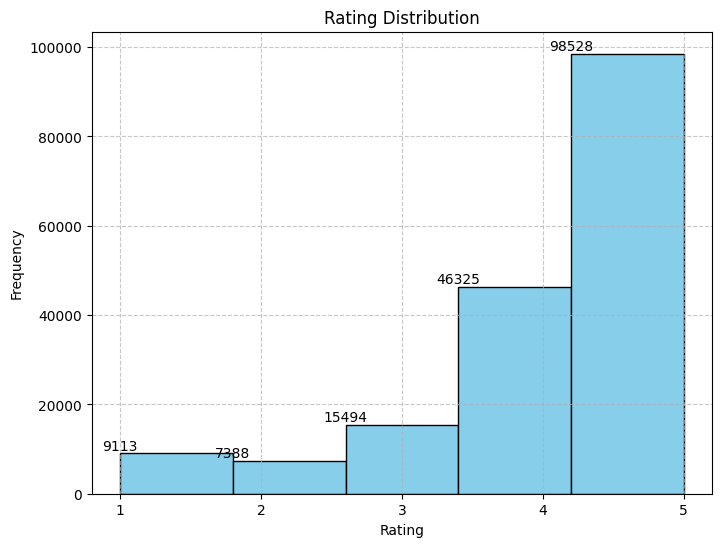

In [ ]:
import matplotlib.pyplot as plt

# Rating Distribution (Histogram)
plt.figure(figsize=(8, 6))
hist, bins, _ = plt.hist(df['rating_review'], bins=5, color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.grid(True, linestyle='--', alpha=0.7)

# Adding count labels
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')

plt.show()


`Rating Variation Over Time`

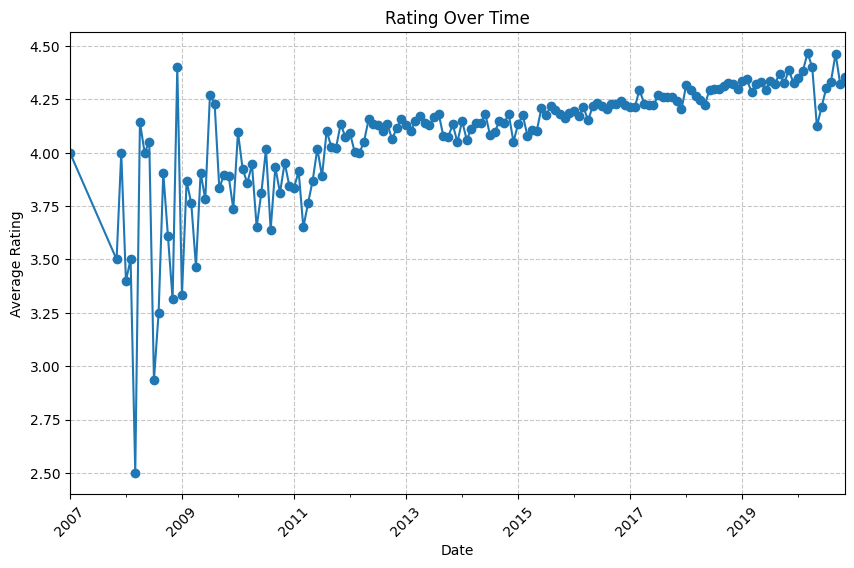

In [ ]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Rating Over Time (Line Plot)
plt.figure(figsize=(10, 6))
df.groupby(df['date'].dt.to_period('M'))['rating_review'].mean().plot(marker='o')
plt.title('Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()


`Review Length Dist.`

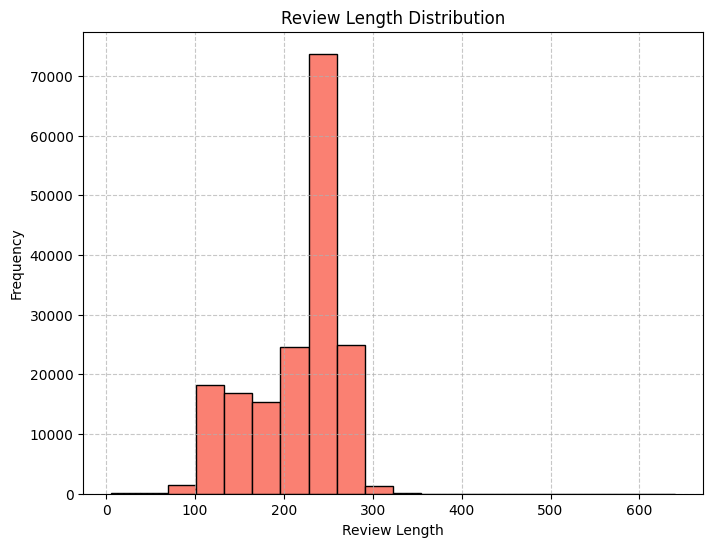

In [ ]:
# Review Length Distribution (Histogram)
review_lengths = df['review_preview'].apply(len)

plt.figure(figsize=(8, 6))
plt.hist(review_lengths, bins=20, color='salmon', edgecolor='black')
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


`Review Word Count Distribution`

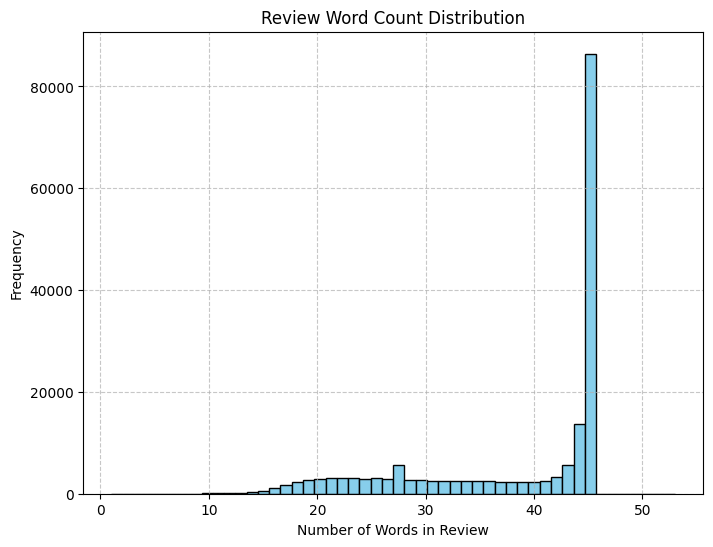

In [ ]:
# Review Length Distribution (Histogram) in words
review_word_counts = df['review_preview'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
plt.hist(review_word_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Review Word Count Distribution')
plt.xlabel('Number of Words in Review')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Feature Engineering

Adding features to the dataframe
- `Sentiment analysis` of the review

- `Emotion analysis` of the review

- `Sentiment shift` in the review (How the tone of the review changes)

- Number of `stop words used` in the review

- `Lenght` of review

- `Ratio of stop word` used to lenght of review

- Precence of `URL`

- `Exclamation` mark usage

- `Punctuation` usage

- Number of `keywords` used

Defining functions to do the new features

In [ ]:
import numpy as np
import re
import string
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from nrclex import NRCLex
from nltk.corpus import stopwords
import nltk

def feature_eng(df):

    # Download stopwords
    nltk.download('stopwords')
    stop_words_english = set(stopwords.words('english'))
    stop_words_spanish = set(stopwords.words('spanish'))
    stop_words = stop_words_english.union(stop_words_spanish)

    # Initialize sentiment analyzer
    vader_analyzer = SentimentIntensityAnalyzer()


    # Function to analyze sentiment
    def analyze_sentiment(text):
        vader_scores = vader_analyzer.polarity_scores(text)
        blob = TextBlob(text)
        return vader_scores['neg'], vader_scores['neu'], vader_scores['pos'], vader_scores['compound'], blob.sentiment.polarity, blob.sentiment.subjectivity


    # Function to analyze emotions
    def analyze_emotions(text):
        emotion = NRCLex(text)
        emotion_scores = emotion.raw_emotion_scores
        # Normalize the emotion scores to ensure they are in a consistent format
        total_scores = sum(emotion_scores.values())
        if total_scores > 0:
            emotion_scores = {k: v / total_scores for k, v in emotion_scores.items()}
        return emotion_scores


    # Function to compute sentiment shift
    def sentiment_shift(text):
        sentences = TextBlob(text).sentences
        if len(sentences) < 2:
            return 0  # Not enough sentences to compute a shift

        vader_scores = [vader_analyzer.polarity_scores(str(sentence))['compound'] for sentence in sentences]
        shifts = np.diff(vader_scores)  # Compute the difference between consecutive sentiment scores
        sentiment_shift_value = np.mean(np.abs(shifts))  # Average of the absolute sentiment shifts
        return sentiment_shift_value


    # Function to add additional features
    def additional_features(text):
        length = len(text)  # Length of the post
        words = text.split()  # Split the text into words
        num_stop_words = sum(1 for word in words if word.lower() in stop_words)  # Number of stop words used in the post
        stop_words_ratio = num_stop_words / length if length > 0 else 0  # Ratio of stop words used in the post
        num_exclamations = text.count('!')  # Number of exclamation marks used in the post
        num_punctuation = sum(1 for char in text if char in string.punctuation)  # Number of punctuation marks used in the post
        url_present = bool(re.search(r'http[s]?://', text))  # Check if a URL is present in the post
        return length, num_stop_words, stop_words_ratio, num_exclamations, num_punctuation, url_present


    # Function to get the most common words excluding stop words
    def get_most_common_words(text_series, n=350):
        all_words = ' '.join(text_series).lower().split()
        word_counts = Counter(all_words)
        most_common_words = [word for word, count in word_counts.most_common(n) if word not in stop_words]
        return most_common_words


    # Function to count keywords in a review
    def count_keywords(text, keywords):
        words = re.findall(r'\b\w+\b', text.lower())
        keyword_count = sum(word in keywords for word in words)
        return keyword_count



    # Apply sentiment analysis
    sentiment_results = df['review_full'].apply(lambda x: analyze_sentiment(x))
    df[['negative', 'neutral', 'positive', 'overall_sentiment', 'blob_polarity', 'blob_subjectivity']] = pd.DataFrame(sentiment_results.tolist(), index=df.index)

    # Apply sentiment shift
    df['sentiment_shift'] = df['review_full'].apply(lambda x: sentiment_shift(x))

    # Apply additional features
    additional_features_results = df['review_full'].apply(lambda x: additional_features(x))
    df[['review_length', 'num_stop_words', 'stop_words_ratio', 'num_exclamations', 'num_punctuation', 'url_present']] = pd.DataFrame(additional_features_results.tolist(), index=df.index)

    # Get the 200 most common words
    most_common_words = get_most_common_words(df['review_full'])

    # Apply keyword count
    df['keyword_count'] = df['review_full'].apply(lambda x: count_keywords(x, most_common_words))

    # Apply emotion analysis
    emotion_results = df['review_full'].apply(lambda x: analyze_emotions(x))

    # Convert emotion results to DataFrame and handle missing values
    emotion_df = pd.DataFrame(emotion_results.tolist()).fillna(0)

    # Add an identifier column to emotion_df
    emotion_df['index'] = df.index

    # Make sure the columns of emotion_df are properly prefixed
    emotion_df.columns = [f'emotion_{col}' if col != 'index' else col for col in emotion_df.columns]

    # Set the index of df to be the same as the original index for merging
    df = df.reset_index()

    # Merge the emotion DataFrame with the original DataFrame on the index
    df = df.merge(emotion_df, left_on='index', right_on='index', how='left')

    # word_count
    df['word_count'] = df['review_full'].apply(lambda x: len(str(x).split()))
    df['word_count'] = df['review_full'].apply(lambda x: len(str(x).split()))

    # unique_word_count
    df['unique_word_count'] = df['review_full'].apply(lambda x: len(set(str(x).split())))
    df['unique_word_count'] = df['review_full'].apply(lambda x: len(set(str(x).split())))

    # mean_word_length
    df['mean_word_length'] = df['review_full'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['mean_word_length'] = df['review_full'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

    # hashtag_count
    df['hashtag_count'] = df['review_full'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['hashtag_count'] = df['review_full'].apply(lambda x: len([c for c in str(x) if c == '#']))

    # mention_count
    df['mention_count'] = df['review_full'].apply(lambda x: len([c for c in str(x) if c == '@']))
    df['mention_count'] = df['review_full'].apply(lambda x: len([c for c in str(x) if c == '@']))

    # Drop the index column as it's no longer needed
    df = df.drop(columns=['index'])

    return df

Applying the previously made function

`New Columns Explanation:`

1.	VADER Scores:
- `vader_neg:` The negative sentiment score from VADER. This score ranges from 0 to 1, indicating the proportion of the text that conveys negative sentiment.

- `vader_neu:` The neutral sentiment score from VADER. This score ranges from 0 to 1, indicating the proportion of the text that conveys neutral sentiment.

- `vader_pos:` The positive sentiment score from VADER. This score ranges from 0 to 1, indicating the proportion of the text that conveys positive sentiment.

- `vader_compound:` The compound sentiment score from VADER. This score ranges from -1 to 1 and is a normalized, weighted composite score that takes into account the overall sentiment of the text.

2.	TextBlob Scores:
- `blob_polarity:` The polarity score from TextBlob. This score ranges from -1 to 1, where -1 indicates a negative sentiment, 0 indicates a neutral sentiment, and 1 indicates a positive sentiment.
	
- `blob_subjectivity:` The subjectivity score from TextBlob. This score ranges from 0 to 1, where 0 is very objective and 1 is very subjective. Higher subjectivity means that the text contains more personal opinions and subjective expressions.


- Sentiment Shifted 
	1.	Text Segmentation:
	•	Sentence 1: “The food was amazing.”
	•	Sentence 2: “However, the service was terrible.”
	2.	Sentiment Analysis:
	•	Sentence 1 Compound Score: 0.8 (positive sentiment)
	•	Sentence 2 Compound Score: -0.6 (negative sentiment)
	3.	Calculate Differences:
	•	Difference: |0.8 - (-0.6)| = 1.4
	4.	Average of Absolute Shifts:
	•	Since there is only one difference, the average is 1.4.

In [ ]:
df = feature_eng(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carloslopez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


`Cleaning the raw text` to have the clean data for the model

In [ ]:
# Import the necessary libraries
from nltk.stem import *
from nltk.corpus import stopwords
import re

# Function to process text data
def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text)
    words = letters_only.lower().split()

    stops = set(stopwords.words("english"))
    not_stop_words = [w for w in words if not w in stops]

    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]

    return( " ".join( stemmed ))

In [ ]:
#Apply the function to the review_full column
df['clean_text'] = df['review_full'].apply(lambda x: process_text(x))
df.head()

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_disgust,emotion_fear,emotion_negative,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text
0,0,1,Sushi_Yakuza,4,Positive,review_731778139,Good sushi option,"The menu of Yakuza is a bit of a lottery, some...","The menu of Yakuza is a bit of a lottery, some...",2019-12-10,...,0.058824,0.117647,0.117647,0.058824,75,55,4.240000,0,0,menu yakuza bit lotteri plate realli good like...
1,10,11,Azotea_Forus_Barcelo,1,Negative,review_766657436,Light up your table at night,Check your bill when you cancel just in case y...,Check your bill when you cancel just in case y...,2020-08-23,...,0.000000,0.166667,0.250000,0.166667,38,35,4.368421,0,0,check bill cancel case get extra charg surpris...
2,11,12,Level_Veggie_Bistro,5,Positive,review_749493592,Delicious,I had the yuca profiteroles and the veggie bur...,I had the yuca profiteroles and the veggie bur...,2020-03-06,...,0.000000,0.000000,0.200000,0.000000,32,26,5.000000,0,0,yuca profiterol veggi burger recommend server ...
3,12,13,Sto_Globo_Sushi_Room,5,Positive,review_772422246,Loved this place,A friend recommended this place as one of the ...,A friend recommended this place as one of the ...,2020-09-29,...,0.000000,0.000000,0.076923,0.000000,85,62,4.270588,0,0,friend recommend place one best sushi ever tri...
4,13,14,Azotea_Forus_Barcelo,5,Positive,review_761855600,Amazing terrace in madrid,Amazing terrace in madrid - great atmosphere a...,Amazing terrace in madrid - great atmosphere a...,2020-07-27,...,0.000000,0.000000,0.000000,0.000000,21,20,4.714286,0,0,amaz terrac madrid great atmospher great wine ...


Displaying the `final dataframe `

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id,negative,neutral,positive,overall_sentiment,blob_polarity,blob_subjectivity,sentiment_shift,review_length,num_stop_words,stop_words_ratio,num_exclamations,num_punctuation,url_present,keyword_count,emotion_anticipation,emotion_joy,emotion_positive,emotion_surprise,emotion_trust,emotion_anger,emotion_disgust,emotion_fear,emotion_negative,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text
0,0,1,Sushi_Yakuza,4,Positive,review_731778139,Good sushi option,"The menu of Yakuza is a bit of a lottery, some...","The menu of Yakuza is a bit of a lottery, some...",2019-12-10,Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_0,0.059,0.756,0.185,0.9076,0.400000,0.657143,0.129700,392,39,0.099490,0,9,False,13,0.176471,0.058824,0.235294,0.058824,0.058824,0.058824,0.058824,0.117647,0.117647,0.058824,75,55,4.240000,0,0,menu yakuza bit lotteri plate realli good like...
1,10,11,Azotea_Forus_Barcelo,1,Negative,review_766657436,Light up your table at night,Check your bill when you cancel just in case y...,Check your bill when you cancel just in case y...,2020-08-23,Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_1,0.243,0.712,0.045,-0.8472,-0.382812,0.550000,0.427067,205,20,0.097561,3,4,False,5,0.000000,0.083333,0.166667,0.083333,0.000000,0.083333,0.000000,0.166667,0.250000,0.166667,38,35,4.368421,0,0,check bill cancel case get extra charg surpris...
2,11,12,Level_Veggie_Bistro,5,Positive,review_749493592,Delicious,I had the yuca profiteroles and the veggie bur...,I had the yuca profiteroles and the veggie bur...,2020-03-06,Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_2,0.000,0.634,0.366,0.9391,0.500000,0.625000,0.412750,191,18,0.094241,1,4,False,6,0.000000,0.400000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,32,26,5.000000,0,0,yuca profiterol veggi burger recommend server ...
3,12,13,Sto_Globo_Sushi_Room,5,Positive,review_772422246,Loved this place,A friend recommended this place as one of the ...,A friend recommended this place as one of the ...,2020-09-29,Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_3,0.000,0.779,0.221,0.9630,0.574375,0.615000,0.441725,448,41,0.091518,1,6,False,20,0.076923,0.230769,0.384615,0.076923,0.153846,0.000000,0.000000,0.000000,0.076923,0.000000,85,62,4.270588,0,0,friend recommend place one best sushi ever tri...
4,13,14,Azotea_Forus_Barcelo,5,Positive,review_761855600,Amazing terrace in madrid,Amazing terrace in madrid - great atmosphere a...,Amazing terrace in madrid - great atmosphere a...,2020-07-27,Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_4,0.000,0.489,0.511,0.9571,0.516667,0.616667,0.000000,119,7,0.058824,0,2,False,8,0.166667,0.166667,0.166667,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,21,20,4.714286,0,0,amaz terrac madrid great atmospher great wine ...


### `Word analysis`

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.util import ngrams
from wordcloud import WordCloud
import nltk


nltk.download('stopwords')



# Create a copy of the DataFrame for word analysis
df_words = df.copy()

# Preprocess text: tokenize, remove punctuation, and stop words
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df_words['tokens'] = df_words['clean_text'].apply(preprocess)

# Word Frequency Analysis
all_tokens = [token for tokens in df_words['tokens'] for token in tokens]
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)

# Plotting Word Frequency
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Bigram Analysis
def generate_bigrams(text):
    tokens = preprocess(text)
    bigrams = list(ngrams(tokens, 2))
    return [' '.join(bigram) for bigram in bigrams]

df_words['bigrams'] = df_words['clean_text'].apply(generate_bigrams)

# Bigram Frequency Analysis
all_bigrams = [bigram for bigrams in df_words['bigrams'] for bigram in bigrams]
bigram_freq = Counter(all_bigrams)
most_common_bigrams = bigram_freq.most_common(20)

# Plotting Bigram Frequency
bigrams, counts = zip(*most_common_bigrams)
plt.figure(figsize=(10, 6))
plt.bar(bigrams, counts, color='salmon')
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()



# Load Cleaned Data

In [6]:
# data_cleaned = pd.read_csv('unused_data/Madrid_reviews_cleaned.csv')
data_cleaned = pd.read_parquet('madrid_reviews_cleaned.parquet', engine='pyarrow')

In [ ]:
data_cleaned['clean_text'] = data_cleaned['clean_text'].astype(str) 

In [ ]:
data_cleaned['review_full'] = data_cleaned['review_full'].astype(str) 
data_cleaned.head()

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_disgust,emotion_fear,emotion_negative,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text
0,0,1,Sushi_Yakuza,4,Positive,review_731778139,Good sushi option,"The menu of Yakuza is a bit of a lottery, some...","The menu of Yakuza is a bit of a lottery, some...",2019-12-10,...,0.058824,0.117647,0.117647,0.058824,75,55,4.240000,0,0,menu yakuza bit lotteri plate realli good like...
1,10,11,Azotea_Forus_Barcelo,1,Negative,review_766657436,Light up your table at night,Check your bill when you cancel just in case y...,Check your bill when you cancel just in case y...,2020-08-23,...,0.000000,0.166667,0.250000,0.166667,38,35,4.368421,0,0,check bill cancel case get extra charg surpris...
2,11,12,Level_Veggie_Bistro,5,Positive,review_749493592,Delicious,I had the yuca profiteroles and the veggie bur...,I had the yuca profiteroles and the veggie bur...,2020-03-06,...,0.000000,0.000000,0.200000,0.000000,32,26,5.000000,0,0,yuca profiterol veggi burger recommend server ...
3,12,13,Sto_Globo_Sushi_Room,5,Positive,review_772422246,Loved this place,A friend recommended this place as one of the ...,A friend recommended this place as one of the ...,2020-09-29,...,0.000000,0.000000,0.076923,0.000000,85,62,4.270588,0,0,friend recommend place one best sushi ever tri...
4,13,14,Azotea_Forus_Barcelo,5,Positive,review_761855600,Amazing terrace in madrid,Amazing terrace in madrid - great atmosphere a...,Amazing terrace in madrid - great atmosphere a...,2020-07-27,...,0.000000,0.000000,0.000000,0.000000,21,20,4.714286,0,0,amaz terrac madrid great atmospher great wine ...


# Zero Shot Classification - Restaurant Rating

In [ ]:
# Function to create the zero-shot classification pipeline
def create_classifier(model_name):
    return pipeline("zero-shot-classification", model=model_name)

# Function to classify a single piece of text
def classify_text(text, classifier, labels):
    result = classifier(text, labels)
    return result['labels'][0]  # The label with the highest score

# Function to classify text in parallel
def parallel_classify_texts(texts, classifier, labels, num_threads):
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(tqdm(executor.map(lambda text: classify_text(text, classifier, labels), texts), total=len(texts)))
    return results

# Process the DataFrame in chunks and save each chunk to a CSV
def process_and_save_chunks(data, chunk_size, num_threads, output_dir, model_name, labels):
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    chunks = [data[i:i + chunk_size] for i in range(0, data.shape[0], chunk_size)]
    
    classifier = create_classifier(model_name)

    for i, chunk in enumerate(chunks):
        chunk['predicted_label'] = parallel_classify_texts(chunk['review_full'], classifier, labels, num_threads)

        # Optionally, convert labels to ratings
        def convert_label_to_rating(label):
            label_to_rating = {
                "very bad review": 1,
                "bad review": 2,
                "average review": 3,
                "good review": 4,
                "very good review": 5
            }
            return label_to_rating[label]

        chunk['predicted_rating'] = chunk['predicted_label'].apply(convert_label_to_rating)

        # Save the chunk to a CSV file
        chunk.to_csv(os.path.join(output_dir, f'chunk_{i}.csv'), index=False)

        # Print progress
        print(f'Saved chunk {i} to CSV.')


def read_all_csvs_in_folder(folder_path):
    # List to hold the individual DataFrames
    df_list = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            # Append the DataFrame to the list
            df_list.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)

    return combined_df

## Llama 2

We attempted to run llama both locally and on colab however, it would kill the kernel while loading the model. Given more computing power we would attempt other models.

## bart-large-mnli

In [ ]:

model = "facebook/bart-large-mnli"
labels = ["very bad review", "bad review", "average review", "good review", "very good review"]
output_dir='processed_chunks_bart'
# process_and_save_chunks(data_cleaned, chunk_size=1000, num_threads=4, output_dir=output_dir, model_name=model, labels=labels)

In [ ]:
bart = read_all_csvs_in_folder(output_dir)
bart['rating_diff']=bart['predicted_rating']-bart['rating_review']
bart['predicted_rating'].value_counts().sort_index()
percent_of_total = bart['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

In [ ]:
rating_diff_counts = bart['rating_diff'].value_counts().sort_index()
percent_of_total = bart['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total

rating_diff
-3    0.001
-2    0.001
-1    0.440
 0    0.508
 1    0.046
 2    0.004
Name: proportion, dtype: float64

## RoBERTa

In [ ]:

model = "roberta-large-mnli"
labels = ["very bad review", "bad review", "average review", "good review", "very good review"]
output_dir='processed_chunks_roberta'

# process_and_save_chunks(data_cleaned, chunk_size=1000, num_threads=4, output_dir=output_dir, model_name=model, labels=labels)

In [ ]:
roberta = read_all_csvs_in_folder(output_dir)
roberta['rating_diff']=roberta['predicted_rating']-roberta['rating_review']
roberta['predicted_rating'].value_counts().sort_index()
percent_of_total = roberta['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
1    0.009723
2    0.032383
3    0.052213
4    0.831106
5    0.074574
Name: proportion, dtype: float64

In [ ]:
rating_diff_counts = roberta['rating_diff'].value_counts().sort_index()
percent_of_total = roberta['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total

rating_diff
-4    0.000064
-3    0.001596
-2    0.008596
-1    0.688574
 0    0.262170
 1    0.032894
 2    0.004362
 3    0.001383
 4    0.000362
Name: proportion, dtype: float64

## DeBERTa

In [ ]:

model = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
labels = ["very bad review", "bad review", "average review", "good review", "very good review"]
output_dir='processed_chunks_deberta'

# process_and_save_chunks(data_cleaned, chunk_size=1000, num_threads=4, output_dir=output_dir, model_name=model, labels=labels)

In [ ]:
deberta = read_all_csvs_in_folder(output_dir)
deberta['rating_diff']=deberta['predicted_rating']-deberta['rating_review']
deberta['predicted_rating'].value_counts().sort_index()
percent_of_total = roberta['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
1    0.009723
2    0.032383
3    0.052213
4    0.831106
5    0.074574
Name: proportion, dtype: float64

In [ ]:
rating_diff_counts = deberta['rating_diff'].value_counts().sort_index()
percent_of_total = deberta['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total

rating_diff
-4    0.00006
-3    0.00386
-2    0.01224
-1    0.35848
 0    0.53956
 1    0.07870
 2    0.00518
 3    0.00162
 4    0.00030
Name: proportion, dtype: float64

## DistilBERT

In [ ]:

model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
labels = ["very bad review", "bad review", "average review", "good review", "very good review"]
output_dir='processed_chunks_distilbert'

# process_and_save_chunks(data_cleaned, chunk_size=1000, num_threads=4, output_dir=output_dir, model_name=model, labels=labels)

In [ ]:
distilbert = read_all_csvs_in_folder(output_dir)
distilbert['rating_diff']=distilbert['predicted_rating']-distilbert['rating_review']
distilbert['predicted_rating'].value_counts().sort_index()
percent_of_total = roberta['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
1    0.009723
2    0.032383
3    0.052213
4    0.831106
5    0.074574
Name: proportion, dtype: float64

In [ ]:
rating_diff_counts = distilbert['rating_diff'].value_counts().sort_index()
percent_of_total = distilbert['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total 

rating_diff
-3    0.001333
-1    0.002333
 0    0.793000
 1    0.138667
 2    0.036000
 3    0.017000
 4    0.011667
Name: proportion, dtype: float64

## Flan T-5

In [ ]:

model = "sjrhuschlee/flan-t5-base-mnli"
labels = ["very bad review", "bad review", "average review", "good review", "very good review"]
output_dir='processed_chunks_flan-t5'

# process_and_save_chunks(data_cleaned, chunk_size=1000, num_threads=4, output_dir=output_dir, model_name=model, labels=labels)

In [ ]:
flan_t5 = read_all_csvs_in_folder(output_dir)
flan_t5['rating_diff']=flan_t5['predicted_rating']-flan_t5['rating_review']
flan_t5['predicted_rating'].value_counts().sort_index()
percent_of_total = roberta['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
1    0.009723
2    0.032383
3    0.052213
4    0.831106
5    0.074574
Name: proportion, dtype: float64

In [ ]:
rating_diff_counts = flan_t5['rating_diff'].value_counts().sort_index()
percent_of_total = flan_t5['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total 

rating_diff
-4    0.0010
-3    0.0310
-2    0.0065
-1    0.3395
 0    0.5325
 1    0.0650
 2    0.0155
 3    0.0080
 4    0.0010
Name: proportion, dtype: float64

## Comparing Models

In [ ]:
dataframes = {
    'flan_t5': flan_t5,
    'distilBERT': distilbert,
    'deBERTa': deberta,
    'RoBERTa': roberta,
    'bart': bart
}

# Create an empty list to store the value_counts dataframes
count_dfs = []

for name, df in dataframes.items():
    counts = df['predicted_rating'].value_counts(normalize=True).sort_index()
    counts_df = counts.reset_index()
    counts_df.columns = ['rating', name]
    count_dfs.append(counts_df)

# Merge all count dataframes on the 'rating' column
result_df = count_dfs[0]
for count_df in count_dfs[1:]:
    result_df = result_df.merge(count_df, on='rating', how='outer')

# Fill NaN values with 0 (optional, if you expect missing ratings)
result_df = result_df.fillna(0)

print(result_df)

   rating  flan_t5  distilBERT  deBERTa   RoBERTa   bart
0       1   0.0020    0.000000  0.00494  0.009723  0.006
1       2   0.0555    0.002000  0.05592  0.032383  0.046
2       3   0.0025    0.000000  0.03060  0.052213  0.019
3       4   0.4555    0.003333  0.46050  0.831106  0.520
4       5   0.4845    0.994667  0.44804  0.074574  0.409


In [ ]:
count_dfs = []

for name, df in dataframes.items():
    counts = df['rating_diff'].value_counts(normalize=True).sort_index()
    counts_df = counts.reset_index()
    counts_df.columns = ['rating_diff', name]
    count_dfs.append(counts_df)

# Merge all count dataframes on the 'rating' column
result_df = count_dfs[0]
for count_df in count_dfs[1:]:
    result_df = result_df.merge(count_df, on='rating_diff', how='outer')

# Fill NaN values with 0 (optional, if you expect missing ratings)
result_df = result_df.fillna(0)

print(result_df)

   rating_diff  flan_t5  distilBERT  deBERTa   RoBERTa   bart
0           -4   0.0010    0.000000  0.00006  0.000064  0.000
1           -3   0.0310    0.001333  0.00386  0.001596  0.001
2           -2   0.0065    0.000000  0.01224  0.008596  0.001
3           -1   0.3395    0.002333  0.35848  0.688574  0.440
4            0   0.5325    0.793000  0.53956  0.262170  0.508
5            1   0.0650    0.138667  0.07870  0.032894  0.046
6            2   0.0155    0.036000  0.00518  0.004362  0.004
7            3   0.0080    0.017000  0.00162  0.001383  0.000
8            4   0.0010    0.011667  0.00030  0.000362  0.000


## Challenges Encountered 

Oringinally the text given to the classifier was a cleaned text and the labels given were:
```python
['very bad', 'bad', 'neutral', 'good', 'very good']
```
However with this approache we encountered a problem, some rating were extremely misclassified. The idea of conducting zero-shot calssification is that the rating itself would be free from bias. However, scathing reviews were given a 4/5 which would be too inacurrate.



![Image Description](images/misclassification.jpeg)


The solution was to change the clean text for the review_full column and change the labels to:
```python
["very bad review", "bad review", "average review", "good review", "very good review"]
```
This allows the classifier to infer more context on the nature of the task and classifies more accurately. Below is an example of the differences in performance. rating_review is the user rating, dirty_text is the review_full column, clean_text is the processed text, and review_in_label in the version we used with review full and the above labels.

![Image Description](images/comparing_roberta_models.png)

# Zero Shot Classification - Restaurant Cuisine

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import concurrent.futures
import os

# Function to create the zero-shot classification pipeline
def create_classifier(model_name):
    return pipeline("zero-shot-classification", model=model_name)

# Function to classify a single piece of text
def classify_text(row, classifier, labels):
    text = f"Restaurant Name: {row['restaurant_name']} - Review Title: {row['title_review']} - Review Full: {row['review_full']}"
    result = classifier(text, labels)
    return result['labels'][0]  # The label with the highest score

# Define chunk size
chunk_size = 1000  # Adjust as needed

# Number of threads to use (adjust as needed)
num_threads = 4  # Use a small number of threads to limit CPU usage

# Wrap your pandas apply with tqdm for a progress bar
tqdm.pandas()

# Function to classify text in parallel
def parallel_classify_texts(df, classifier, labels, num_threads):
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(tqdm(executor.map(lambda row: classify_text(row, classifier, labels), [row for _, row in df.iterrows()]), total=len(df)))
    return results

# Process the DataFrame in chunks and save each chunk to a CSV
def process_and_save_chunks(data, chunk_size, num_threads, output_dir, file_name, model_name, labels):
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    chunks = [data[i:i + chunk_size] for i in range(0, data.shape[0], chunk_size)]
    
    classifier = create_classifier(model_name)

    for i, chunk in enumerate(chunks):
        chunk['predicted_cuisine'] = parallel_classify_texts(chunk, classifier, labels, num_threads)
        output_file_path = os.path.join(output_dir, f'{os.path.splitext(file_name)[0]}_chunk_{i}.csv')
        # Save the chunk to a CSV file
        chunk.to_csv(output_file_path, index=False)
        # Print progress
        print(f'Saved chunk {i} of {file_name} to CSV.')

# Process all CSV files in a directory
def process_all_csvs(input_dir, output_dir, model_name, labels):
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_dir, file_name)
            print(f'Processing file: {file_path}')
            data = pd.read_csv(file_path)
            process_and_save_chunks(data, chunk_size, num_threads, output_dir, file_name, model_name, labels)



## RoBERTa

In [ ]:
# Define input and output directories
input_dir = 'processed_chunks_roberta'
output_dir = 'processed_chunks_roberta_cuisine'

# Define model and labels
model_name = "roberta-large-mnli"
cuisine_labels = ["Italian", "Chinese", "Mexican", "Indian", "French", "Japanese", "American", "Thai", "Spanish", "Greek"]

# process_all_csvs(input_dir, output_dir, model_name, cuisine_labels)

In [ ]:
roberta_cuisine = read_all_csvs_in_folder(output_dir)
percent_of_total = roberta_cuisine['predicted_cuisine'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_cuisine
American    0.047556
Chinese     0.007444
French      0.133111
Greek       0.039667
Indian      0.020833
Italian     0.066444
Japanese    0.017944
Mexican     0.154556
Spanish     0.502444
Thai        0.010000
Name: proportion, dtype: float64

In [ ]:
pivot_table = pd.pivot_table(
        roberta_cuisine,
        index='predicted_cuisine',
        columns='restaurant_name',
        values='review_id',
        aggfunc='count',
        fill_value=0
    )
pivot_table

restaurant_name,A_Nora,A_vAnvera,Al_Son_de_Cuba,Albora,Alcaravea_castello,AlliOli_Valencian_Food,Alright,Amicis,Amparito_Roca,Antigua_Casa_de_la_Paella,...,Triana,Txirimiri,Verdejo,Vietnam_Restaurante,Vila_Brasil,Vinos_de_Bellota,YOUnique_Restaurant,Yakiniku_Rikyu,Yakitoro_by_Chicote,Zenith_Brunch_Cocktails
predicted_cuisine,,,,,,,,,,,,,,,,,,,,,
American,0,0,0,0,0,0,49,9,0,0,...,0,0,0,0,0,1,0,0,0,138
Chinese,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,1,0
French,0,2,0,4,0,0,2,13,1,0,...,1,7,0,3,0,28,28,0,19,42
Greek,1,1,0,2,0,0,2,151,0,0,...,10,8,0,0,0,3,0,0,0,6
Indian,0,0,0,0,0,0,1,1,0,0,...,0,1,0,2,0,0,0,0,2,1
Italian,0,36,0,1,0,0,2,26,0,0,...,0,1,0,0,0,1,2,0,0,0
Japanese,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,16,0
Mexican,0,0,0,0,0,0,4,18,3,5,...,9,41,0,0,11,14,0,0,11,1
Spanish,2,11,4,3,7,23,30,158,7,40,...,14,62,19,16,12,108,9,0,17,93


## Deberta

In [ ]:
# Define input and output directories
input_dir = 'processed_chunks_deberta'
output_dir = 'processed_chunks_deberta_cuisine'

# Define model and labels
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
cuisine_labels = ["Italian", "Chinese", "Mexican", "Indian", "French", "Japanese", "American", "Thai", "Spanish", "Greek"]

# process_all_csvs(input_dir, output_dir, model_name, cuisine_labels)

In [ ]:
roberta_cuisine = read_all_csvs_in_folder(output_dir)
percent_of_total = roberta_cuisine['predicted_cuisine'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_cuisine
American    0.031316
Chinese     0.004684
French      0.119289
Greek       0.006158
Indian      0.020605
Italian     0.136895
Japanese    0.024395
Mexican     0.020921
Spanish     0.630474
Thai        0.005263
Name: proportion, dtype: float64

In [ ]:
pivot_table = pd.pivot_table(
        roberta_cuisine,
        index='predicted_cuisine',
        columns='restaurant_name',
        values='review_id',
        aggfunc='count',
        fill_value=0
    )
pivot_table

restaurant_name,99_Sushi_Bar,99_Sushi_Bar_Padre_Damian,A_Barra,A_vAnvera,Abaceria_Tapas_Lambuzo_Conchas,Ablanedo,Adrede,Albora,Alcaravea,Alcaravea_castello,...,Vila_Brasil,Villoldo,Vinitus_Gran_Via_Madrid,Vinos_de_Bellota,Vinoteca_Garcia_de_la_Navarra,Viridiana,Yakiniku_Rikyu,Yokaloka,Zalacain,Zenith_Brunch_Cocktails
predicted_cuisine,,,,,,,,,,,,,,,,,,,,,
American,2,1,0,0,0,0,0,0,2,0,...,6,0,0,1,1,0,0,0,1,99
Chinese,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
French,1,0,6,0,0,0,15,1,1,0,...,1,1,0,50,5,1,0,1,41,65
Greek,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
Indian,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Italian,0,0,9,38,6,2,0,4,7,2,...,2,4,0,18,22,0,0,0,6,7
Japanese,36,20,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,5,40,0,6
Mexican,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
Spanish,13,8,38,13,47,5,24,5,79,5,...,99,9,64,85,92,9,0,9,53,119


# Exporting Data

In [ ]:
roberta = read_all_csvs_in_folder('processed_chunks_roberta')
cuisine_roberta = read_all_csvs_in_folder('processed_chunks_roberta_cuisine')


deberta = read_all_csvs_in_folder('processed_chunks_deberta')
cuisine_deberta = read_all_csvs_in_folder('processed_chunks_deberta_cuisine')


roberta['model_used']='RoBERTa'
roberta['rating_diff']=roberta['predicted_rating']-roberta['rating_review']

cuisine_roberta['model_used']='RoBERTa'
cuisine_roberta['rating_diff']=cuisine_roberta['predicted_rating']-cuisine_roberta['rating_review']


deberta['model_used']='DeBERTa'
deberta['rating_diff']=deberta['predicted_rating']-deberta['rating_review']

cuisine_deberta['model_used']='DeBERTa'
cuisine_deberta['rating_diff']=cuisine_deberta['predicted_rating']-cuisine_deberta['rating_review']

pd.concat([roberta, deberta]).to_csv('data_final_no_cuisine.csv', index=False)
pd.concat([cuisine_roberta, cuisine_deberta]).to_csv('data_final_cuisine.csv', index=False)

In [ ]:

# Read CSV file into DataFrame
df = pd.read_csv('data_final_no_cuisine.csv')
df.to_parquet('data_final_no_cuisine.parquet', engine='pyarrow', index=False)

df = pd.read_csv('data_final_cuisine.csv')
df.to_parquet('data_final_cuisine.parquet', engine='pyarrow', index=False)